In [1]:
!pip install emoji==1.6.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.2/174.2 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-1.6.3-py3-none-any.whl size=170298 sha256=30d2bd105391d03e173154dbb0ac00b4964409fda8cea42f4aa377c462d9ec7e
  Stored in directory: /root/.cache/pip/wheels/83/42/4a/2e5a7b28b80e3a4f143cb5bbfcfbfe54958ccb533bb8ce2a99
Successfully built emoji


In [2]:
import re
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import emoji
import itertools 
from collections import Counter
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

## *Preparation and reading data*

In [3]:
def rawToDf(file, key):
    '''Converts raw .txt file into a Data Frame'''
    
    split_formats = {
        '12hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s[APap][mM]\s-\s',
        '24hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s-\s',
        'custom' : ''
    }
    datetime_formats = {
        '12hr' : '%d/%m/%Y, %I:%M %p - ',
        '24hr' : '%d/%m/%Y, %H:%M - ',
        'custom': ''
    }
    
    with open(file, 'r', encoding='utf-8') as raw_data:
        # print(raw_data.read())
        raw_string = ' '.join(raw_data.read().split('\n')) # converting the list split by newline char. as one whole string as there can be multi-line messages
        user_msg = re.split(split_formats[key], raw_string) [1:] # splits at all the date-time pattern, resulting in list of all the messages with user names
        date_time = re.findall(split_formats[key], raw_string) # finds all the date-time patterns
        
        df = pd.DataFrame({'date_time': date_time, 'user_msg': user_msg}) # exporting it to a df
        
    # converting date-time pattern which is of type String to type datetime,
    # format is to be specified for the whole string where the placeholders are extracted by the method 
    df['date_time'] = pd.to_datetime(df['date_time'], format=datetime_formats[key])
    
    # split user and msg 
    usernames = []
    msgs = []
    for i in df['user_msg']:
        a = re.split('([\w\W]+?):\s', i) # lazy pattern match to first {user_name}: pattern and spliting it aka each msg from a user
        if(a[1:]): # user typed messages
            usernames.append(a[1])
            msgs.append(a[2])
        else: # other notifications in the group(eg: someone was added, some left ...)
            usernames.append("group_notification")
            msgs.append(a[0])

    # creating new columns         
    df['user'] = usernames
    df['message'] = msgs

    # dropping the old user_msg col.
    df.drop('user_msg', axis=1, inplace=True)
    
    return df

In [4]:
df = rawToDf('whatsapp-chat-data.txt', '12hr')

## *Prior Information of my Whatsapp Data*
- This is my most active college coding group.
- It has **235+** participants; 237 to be precise.
- This group was made in **January 2022.**

## Pre-Processing

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13655 entries, 0 to 13654
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date_time  13655 non-null  datetime64[ns]
 1   user       13655 non-null  object        
 2   message    13655 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 320.2+ KB


### The dataset contains 3 rows, and 13655 respective entries.
- Here is how it looks like:

In [6]:
df.sample(10)

,date_time,user,message
1333,2022-02-20 23:43:00,"Tanay Kamath (TSEC, CS)",And then PCE waale teachers literally threaten...
9425,2022-08-06 23:20:00,"Darshan Rander (TSEC, IT)",Settings ig🤔
832,2022-02-14 19:08:00,"Kartik Soneji (TSEC, CS)",
1303,2022-02-20 23:38:00,"Pratik K (TSEC CS, SE)",you will but it'll be same as any other online...
7392,2022-06-12 23:31:00,"Darshan Rander (TSEC, IT)",Yes
12080,2022-09-13 17:13:00,+91 97739 65140,"Now, you will get it"
750,2022-02-12 19:42:00,"Darshan Rander (TSEC, IT)",This should be same our usual factorial program
1131,2022-02-20 22:54:00,+91 77180 82108,Replacement of CS
5267,2022-04-25 09:22:00,"Saurav Upoor (TSEC CS, SE)",
153,2022-01-27 22:04:00,"Rohit Pathak (TSEC, CS)",This message was deleted


In [7]:
df[df['message'] == ""].shape[0]

538

## Adding extra *helper columns for analysis and visualization*

In [8]:
df['day'] = df['date_time'].dt.strftime('%a')
df['month'] = df['date_time'].dt.strftime('%b')
df['year'] = df['date_time'].dt.year
df['date'] = df['date_time'].apply(lambda x: x.date())


### Final Data Frame

In [9]:
df

,date_time,user,message,day,month,year,date
0,2022-01-26 16:19:00,group_notification,Messages and calls are end-to-end encrypted. N...,Wed,Jan,2022,2022-01-26
1,2022-01-24 20:25:00,group_notification,"Tanay Kamath (TSEC, CS) created group ""CODERS👨...",Mon,Jan,2022,2022-01-24
2,2022-01-26 16:19:00,group_notification,You joined using this group's invite link,Wed,Jan,2022,2022-01-26
3,2022-01-26 16:20:00,group_notification,+91 99871 38558 joined using this group's invi...,Wed,Jan,2022,2022-01-26
4,2022-01-26 16:20:00,group_notification,+91 91680 38866 joined using this group's invi...,Wed,Jan,2022,2022-01-26
...,...,...,...,...,...,...,...
13650,2022-10-02 02:05:00,"Darshan Rander (TSEC, IT)",MCQs mark kiya,Sun,Oct,2022,2022-10-02
13651,2022-10-02 02:05:00,"Darshan Rander (TSEC, IT)",Sign-in kiya😂😅,Sun,Oct,2022,2022-10-02
13652,2022-10-02 02:11:00,"Tanay Kamath (TSEC, CS)",Incognito se na?,Sun,Oct,2022,2022-10-02
13653,2022-10-02 02:28:00,"Darshan Rander (TSEC, IT)",Yup,Sun,Oct,2022,2022-10-02


In [10]:
df1 = df.copy()      # I will be using a copy of the original data frame everytime, to avoid loss of data!
df1['message_count'] = [1] * df1.shape[0]      # adding extra helper column --> message_count.
df1.drop(columns='year', inplace=True)         # dropping unnecessary columns, using `inplace=True`, since this is copy of the DF and won't affect the original DataFrame.
df1 = df1.groupby('date').sum().reset_index()  # grouping by date; since plot is of frequency of messages --> no. of messages / day.
df1

,date,message_count
0,2022-01-24,1
1,2022-01-26,105
2,2022-01-27,90
3,2022-01-28,126
4,2022-01-29,118
...,...,...
236,2022-09-28,144
237,2022-09-29,49
238,2022-09-30,167
239,2022-10-01,91


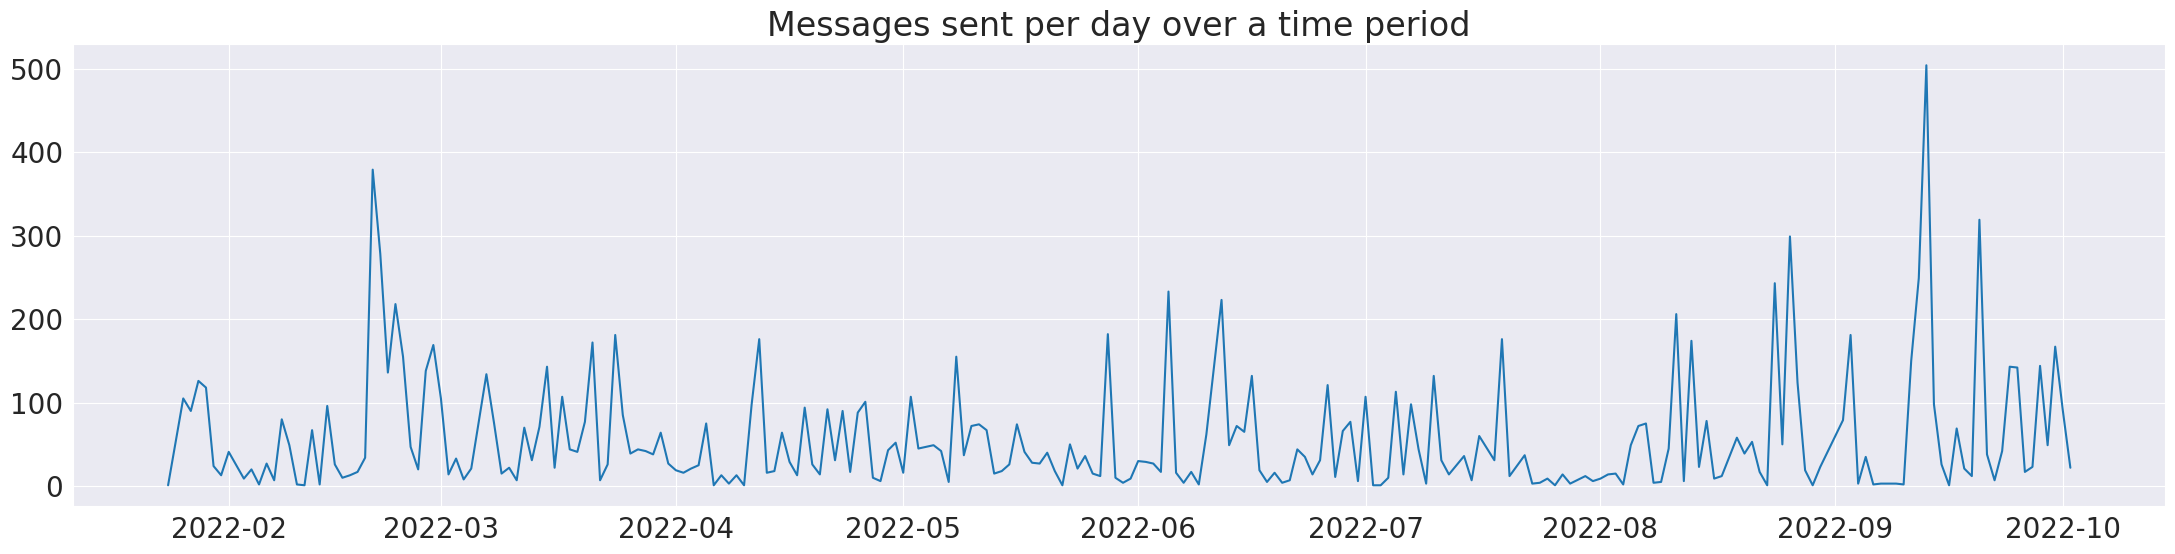

In [40]:
# Improving Default Styles using Seaborn
sns.set_style("darkgrid")

# For better readablity;
import matplotlib
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['figure.figsize'] = (27, 6)      # Same as `plt.figure(figsize = (27, 6))`


# A basic plot
plt.plot(df1.date, df1.message_count)
plt.title('Messages sent per day over a time period');

# Saving the plots
plt.savefig('msg_plots.svg', format = 'svg')

# 2 *Top 10 most active days.*

In [12]:
top10days = df1.sort_values(by="message_count", ascending=False).head(10)    # Sort values according to the number of messages per day.
top10days.reset_index(inplace=True)           # reset index in order.
top10days.drop(columns="index", inplace=True) # dropping original indices.
top10days

,date,message_count
0,2022-09-13,504
1,2022-02-20,379
2,2022-09-20,319
3,2022-08-26,299
4,2022-02-21,278
5,2022-09-12,249
6,2022-08-24,243
7,2022-06-05,233
8,2022-06-12,223
9,2022-02-23,218


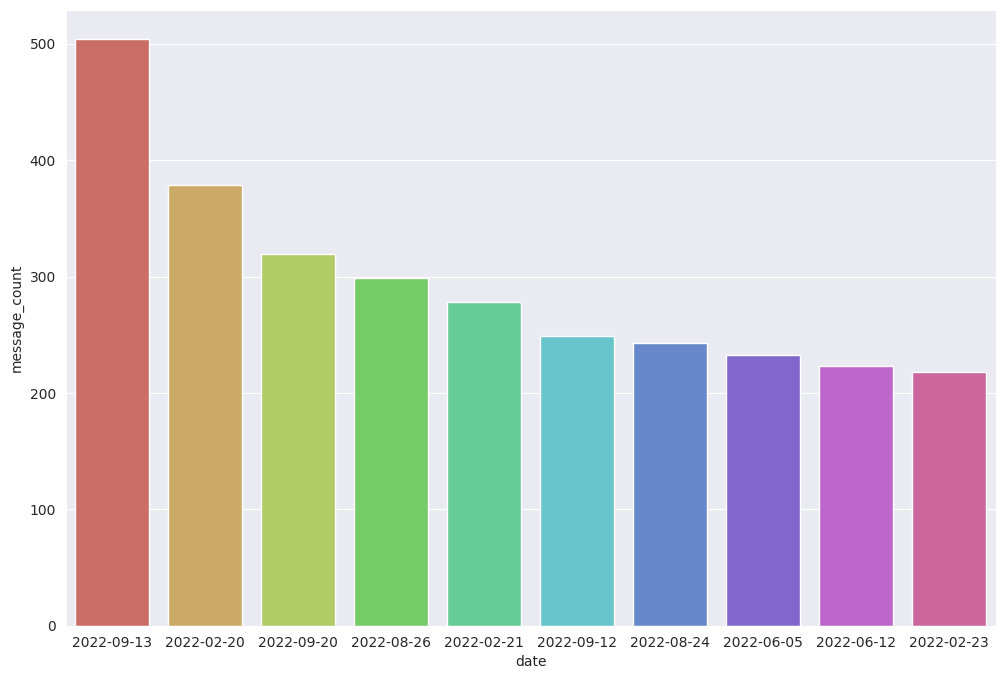

In [13]:
# Improving Default Styles using Seaborn
sns.set_style("darkgrid")

# For better readablity;
import matplotlib
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['figure.figsize'] = (12, 8)

# A bar plot for top 10 days
sns.barplot(x='date', y='message_count', data=top10days, palette="hls");

# Saving the plots
plt.savefig('top10_days.svg', format = 'svg')

#### Apparently, the group was very active on 13th Spetember'20
- Because we were discussing fundamental yet tricky and brain-wracking "Guess the Output" Java questions!

# 3. Top 10 active users on the group.

### Before, analysing that, we will see the *number of Ghosts* in the group.

In [14]:
# Total number of people who have sent at least one message on the group;
print(f"Total number of people who have sent at least one message on the group are {len(df.user.unique()) - 1}")   # `-1` because excluding "group_notficiation"

print(f"Number of people who haven't sent even a single message on the group are {237 - len(df.user.unique()) - 1}")

Total number of people who have sent at least one message on the group are 154
Number of people who haven't sent even a single message on the group are 81


### *Shocking Result*
- Total number of people who have sent at least one message on the group are **154**.
- BUT, the total number of participants were **237**.
- **That means 81 people in the group have not sent even a single message throughout these 9 months and 13500+ messages.**

## Now, pre-processing top 10 active users.

In [15]:
df2 = df.copy()    
df2 = df2[df2.user != "group_notification"]
top10df = df2.groupby("user")["message"].count().sort_values(ascending=False)

# Final Data Frame
top10df = top10df.head(10).reset_index()
top10df

,user,message
0,"Tanay Kamath (TSEC, CS)",2528
1,"Dheeraj Lalwani (TSEC, CS)",1937
2,"Darshan Rander (TSEC, IT)",1404
3,"Kartik Soneji (TSEC, CS)",841
4,"Harsh Kapadia (TSEC IT, SE)",790
5,"Pratik K (TSEC CS, SE)",781
6,"Saurav Upoor (TSEC CS, SE)",569
7,Tushar Nankani,354
8,+91 82916 21138,275
9,"Farhan Irani (TSEC IT, SE)",255


## Now, visualizing top 10 active users.
### *Replacing names with initials for better visualization*

In [16]:
top10df['initials'] = ''
for i in range(10):
    top10df.initials[i] = top10df.user[i].split()[0][0] + top10df.user[i].split()[1][0]
    
top10df.initials[7] = "Me"    # That's me
top10df.initials[8] = "DT"

In [17]:
# For better readablity;
import matplotlib
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (9, 5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

## *Now, We will be trying different visualization methods.*

##### Plotting a simple line graph.

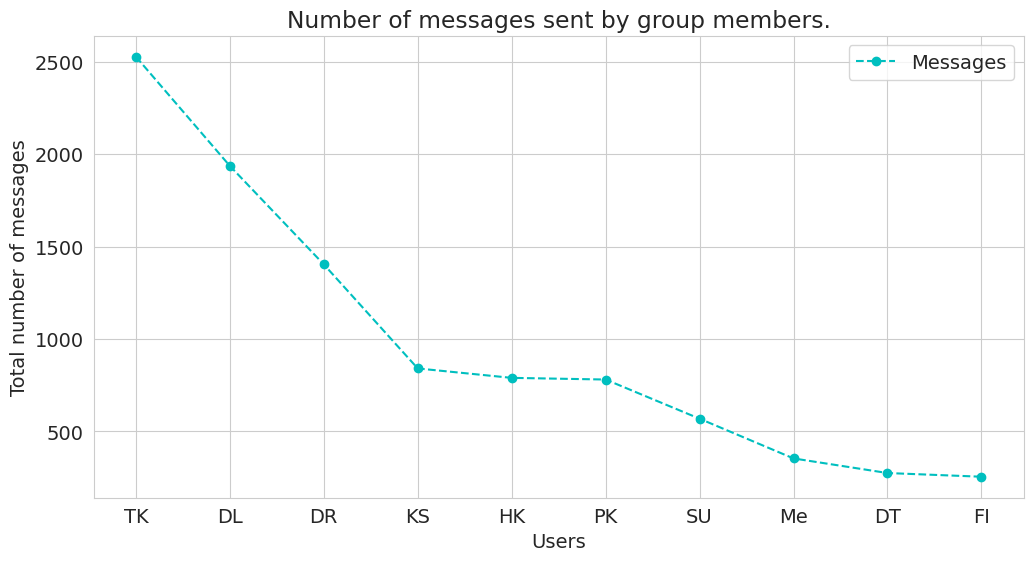

In [18]:
# Improving Default Styles using Seaborn
sns.set_style("whitegrid")

# Increasing the figure size
plt.figure(figsize=(12, 6))


# plt.plot(top10df.initials, top10df.message, marker='o', ls='--', c='cyan')

# BETTER IMPLEMENTATION using the `fmt` argument;
plt.plot(top10df.initials, top10df.message, 'o--c')  


# Labels and Title 
plt.xlabel('Users')
plt.ylabel('Total number of messages')

plt.title("Number of messages sent by group members.")
plt.legend(['Messages']);

# Saving the plots
# plt.savefig('msg_plots.svg', format = 'svg')

#### *Plotting a bar chart and line graph together.*

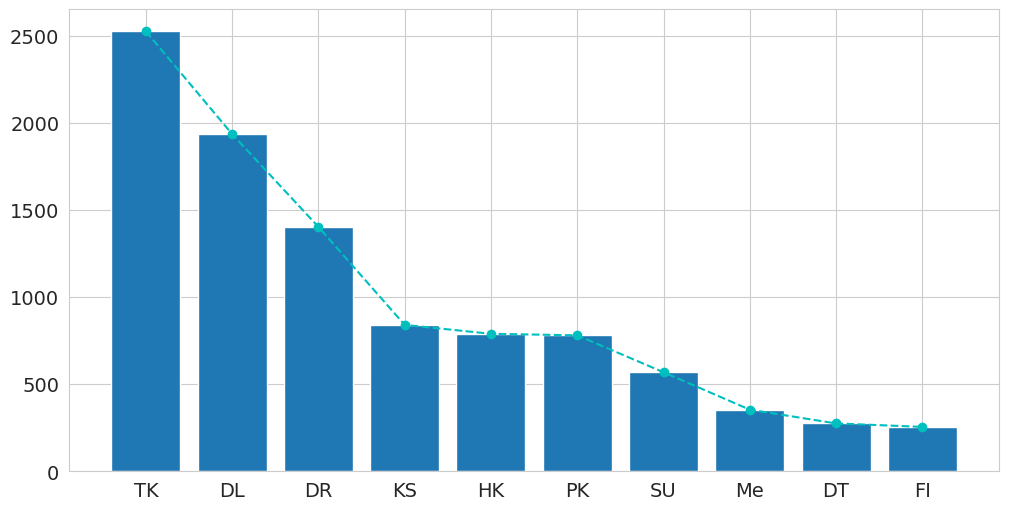

In [19]:
# Improving Default Styles using Seaborn
sns.set_style("whitegrid")

# Increasing the figure size
plt.figure(figsize=(12, 6))

plt.bar(top10df.initials, top10df.message)   # basic bar chart
plt.plot(top10df.initials, top10df.message, 'o--c');   # line chart

### *Beautifying Default Styles using Seaborn*

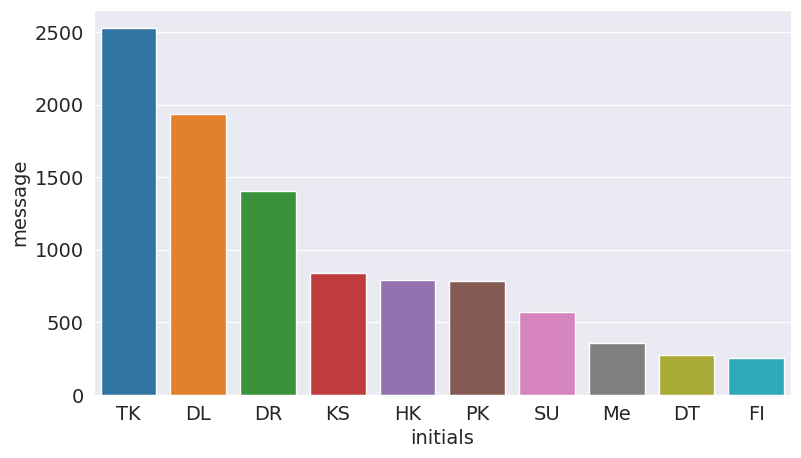

In [20]:
# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")
sns.barplot(x='initials', y='message', data=top10df);

In [21]:
def get_colors_of_certain_order(names_in_certain_order):
    '''the color of a certain person remains the same, no matter the plot'''
    
    order = list(names_in_certain_order)
    return_list = []
    
    for name in order:
        return_list.append(color_dict[name])
        
    return return_list

### Now, we have a really nice set of colours for each person, with which we can visualize using `sns.palplot`.

{'TK': '#F94144',
 'DL': '#F3722C',
 'DR': '#F8961E',
 'KS': '#FDC500',
 'HK': '#F9C74F',
 'PK': '#90BE6D',
 'SU': '#43AA8B',
 'Me': '#577590',
 'DT': '#6D597A',
 'FI': '#003F88'}

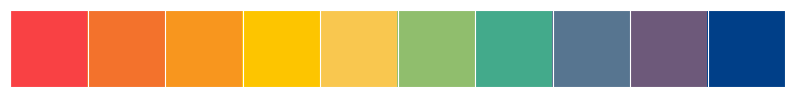

In [22]:
colors = ['#F94144', '#F3722C', '#F8961E', '#FDC500', '#F9C74F', '#90BE6D', '#43AA8B', '#577590', '#6D597A','#003F88']
sns.palplot(colors)    # visualizing the colors' list

names = top10df.initials

color_dict = {}
for name, color in zip(names, colors):
    color_dict[name] = color
color_dict

## Now, finding the *average message length* of the 10 most active users of the group.

In [23]:
# Adding another column for message length; using the apply method;
df2['message_length'] = df2['message'].apply(lambda x: len(x))      

# Creating another dataframe for average length per user;
avg_msg_lengths = df2.groupby(df2.user).mean().reset_index().sort_values(by = 'message_length', ascending = False)

# Creating helper columns;
top10df['avg_message_length'] = [0] * 10
i, j = 0, 0
while i < 10:
    if top10df['user'][i] == avg_msg_lengths['user'][j]:
        top10df['avg_message_length'][i] = avg_msg_lengths['message_length'][j]
        i += 1
        j = -1
    j += 1

# Sorting the average message lengths of the same to 10 active users;
top10df_msg = top10df.sort_values(by = "avg_message_length", ascending=False)

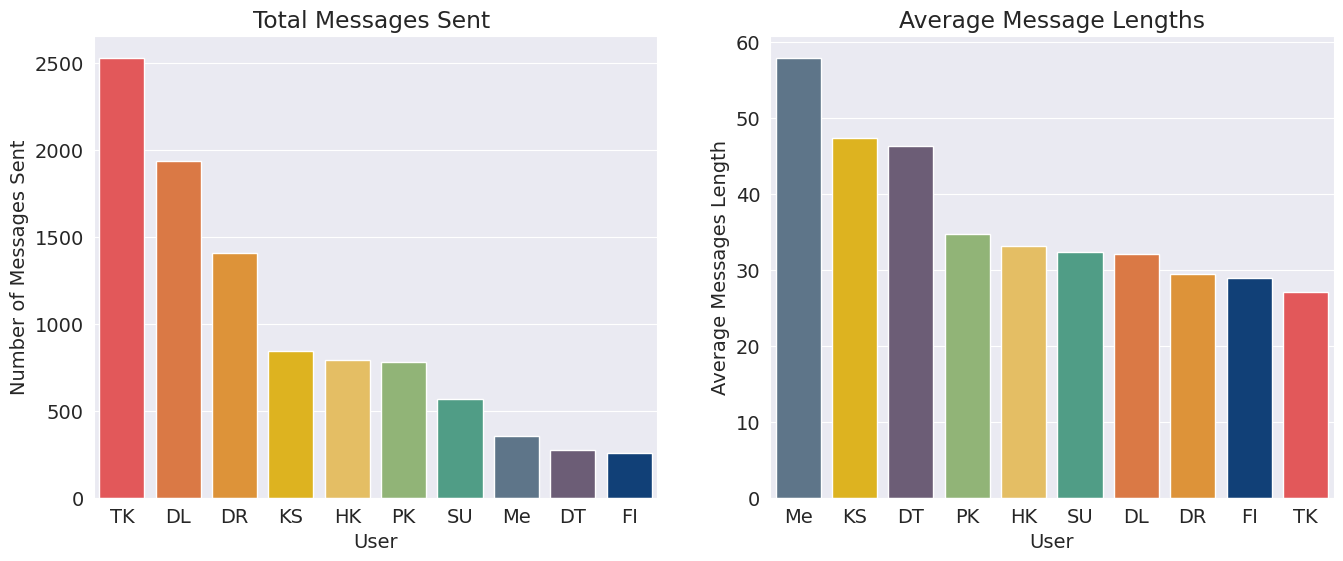

In [24]:
# plotting multiple charts in a grid
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.set_style("darkgrid")

# Plot 1 - Countplot of total messages sent
sns.barplot(x='initials', y='message', data=top10df, ax=axes[0], palette=get_colors_of_certain_order(top10df.initials));
    # Note: the palette argument;

axes[0].set_title('Total Messages Sent ')
axes[0].set_xlabel('User')
axes[0].set_ylabel('Number of Messages Sent')



# Plot 2 - Barplot of those top 10 users' average message lengths
sns.barplot(x='initials', y='avg_message_length', data=top10df_msg, ax=axes[1], palette=get_colors_of_certain_order(top10df_msg.initials))

axes[1].set_title('Average Message Lengths')
axes[1].set_xlabel('User');
axes[1].set_ylabel('Average Messages Length');

# Saving the plots
plt.savefig('top10_msg_plots_diff.svg', format = 'svg')

# 4. Top 10 users most sent media 

- The exported chats were exported without any media files. Any message that contained media was indicated with `‘<Media Omitted> ’`. 

### *Pre-processing*
**We can use this to filter out and see who sends the most media.**

In [25]:
# Using `groupby`, `count` and `sort_values` attributes.
top10media = df[df.message == '<Media omitted> '].groupby('user').count().sort_values(by="message", ascending = False).head(10)

# Dropping unused column;
top10media.drop(columns=['date_time', 'day', 'month', 'year', 'date'], inplace=True)

# Renaming column name for visualization;
top10media.rename(columns={"message": "media_sent"}, inplace=True)

# resetting index;
top10media.reset_index(inplace=True)

top10media['initials'] = ''
for i in range(10):
    top10media.initials[i] = top10media.user[i].split()[0][0] + top10media.user[i].split()[1][0]

top10media.initials[2] = "Me"    # That's me
top10media.initials[9] = "VR"

### Which user sends the most media?

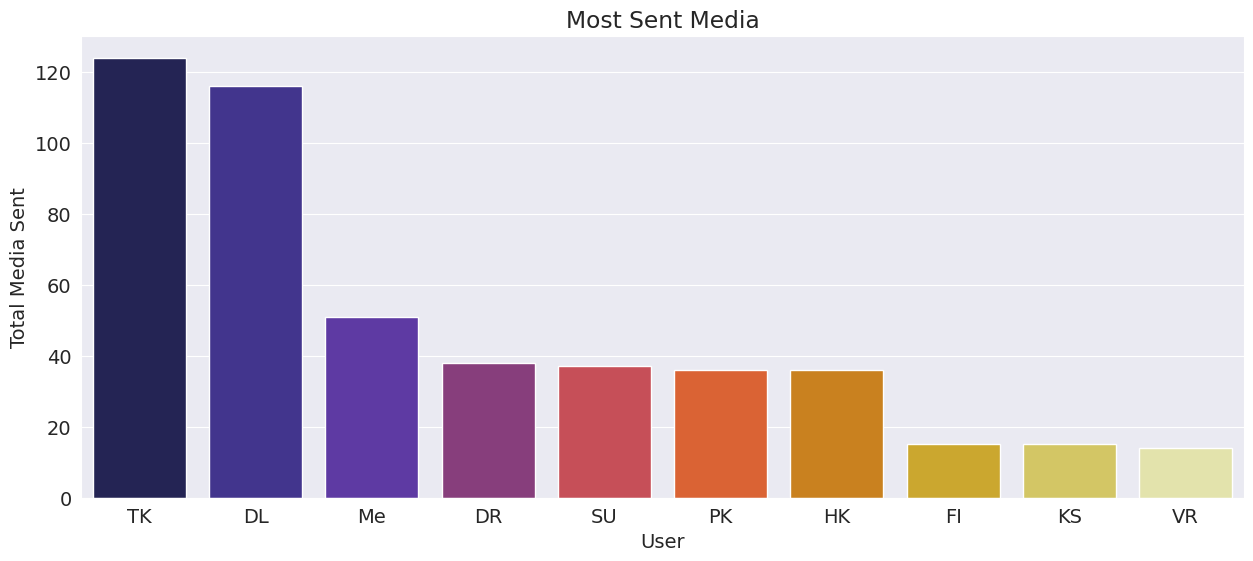

In [26]:
# Increasing the figure size
plt.figure(figsize=(15, 6))

# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")

# Plotting a bar graph;
sns.barplot(x='initials', y='media_sent', data=top10media, palette="CMRmap")

plt.title('Most Sent Media')
plt.xlabel('User')
plt.ylabel('Total Media Sent');

# Saving the plots
plt.savefig('top10media.svg', format = 'svg')

### **TK** is beating everyone by a mile, followed by **DL**. He also ranks the **top** in total messages, *though **last** in average message length*. Most dedicated contributor award goes to **TK**!

# 5. Top 10 most used Emojis
- Will be using the `emoji` module, that was imported earlier.

In [27]:
import re

# List of Unicode values for emojis
emojis_list = ['😀', '😁', '😂', '🤣', '😃', '😄', '😅', '😆', '😉', '😊', '😋', '😌', '😍', '😘', '😜', '😝', '😛', '🤑', '🤗', '🤔', '🤐', '🤢', '🤕', '🤒', '😎', '🤓', '🙁', '☹️', '😷', '🤧', '😞', '😟', '😢', '😭', '😤', '😠', '😡', '💩', '👍', '👎', '👌', '👊', '✊', '🤛', '🤜', '🤝', '🙏', '👏', '👋', '🤙', '💪', '👀', '👃', '👂', '👅', '👄', '💋', '👶', '🧒', '👦', '👧', '🧑', '👱', '👨', '🧔', '👩', '👱‍♀️', '👩‍🦱', '👩‍🦰', '👱‍♂️', '👨‍🦱', '👨‍🦲', '🧓', '👴', '👵', '🙍', '🙎', '🙅', '🙆', '💁', '🙋', '🙇', '🤦', '🤷', '💆', '💇', '🚶', '🏃', '💃', '🕺', '👯', '👫', '👬', '👭', '💏', '👩‍❤️‍💋‍👨', '👨‍❤️‍💋‍👨', '👩‍❤️‍💋‍👩', '💑', '👩‍❤️‍👨', '👨‍❤️‍👨', '👩‍❤️‍👩', '👪', '👨‍👩‍👦', '👨‍👩‍👧', '👨‍👩‍👧‍👦', '👨‍👩‍👦‍👦', '👨‍👩‍👧‍👧', '👨‍👨‍👦', '👨‍👨‍👧', '👨‍👨‍👧‍👦', '😎', '💕', '🤔', '😉', '🎶', '😇', '👌', '🌹', '👏', '🤗', '🙌', '💪', '🤷', '💔', '🎂', '🎁', '🤩', '😋', '🍀', '😜', '🌞', '🌈', '🌺', '🎊', '🎈', '🎓', '💼', '💰', '💳', '🔑', '📅', '📌', '📚', '📝', '🔍', '🔎', '🔥', '🍔', '🍕', '🍟', '🍩', '🍦', '🍭', '🥇', '🥈', '🥉', '🏆', '🚀', '🚗', '🚲', '🛵', '🏍️', '🚁', '🛳️', '🚢', '🛬', '🛫', '🛸', '🛰️', '🎮', '🎲', '🎬', '🎤', '🎧', '🎭', '🎨', '🎬', '🎤', '🎧', '🎭', '🎨', '🎬', '🎤', '🎧', '🎭', '🎨', '🎸', '🥁', '🎻', '🎹', '🎺', '🎬', '🎤', '🎧', '🎭', '🎨', '📷', '🎥', '🔭', '🔬', '🧬', '🧪', '🧫', '🚪', '🧹', '🧼', '🧽', '🚽', '🛏️', '🛋️', '🚿', '🚽', '🚰', '🛁', '💡', '🔦', '🕯️', '🧯', '🔌', '🔋', '💻', '🖥️', '🖨️', '📱', '📞', '📧', '📫', '📦', '🚚', '🚛', '🚜', '🛺', '🚔', '🚑', '🚒', '🚓', '🚕', '🚗', '🚙', '🛵', '🏍️', '🛴', '🛹', '🚂', '🚆', '🚅', '🚄', '🚈', '🚇', '🚊', '🚉', '🚝', '🚞', '🛸', '🚁', '🛩️', '🛫', '🛬', '🚀']


emoji_ctr = Counter()
r = re.compile('|'.join(re.escape(p) for p in emojis_list))

for idx, row in df.iterrows():
    emojis_found = r.findall(row["message"])
    for emoji_found in emojis_found:
        emoji_ctr[emoji_found] += 1

#### Will create another helper column using `emoji.demojize("<emoji>")`, since emojis will not rendered.

In [28]:
# Create DataFrame of top 10 emojis
top10emojis = pd.DataFrame()
top10emojis['emoji'] = [''] * 10
top10emojis['emoji_count'] = [0] * 10
top10emojis['emoji_description'] = [''] * 10

i = 0
for item in emoji_ctr.most_common(10):
    # Add top 10 data of emojis to DataFrame
    top10emojis.emoji[i] = item[0]
    top10emojis.emoji_count[i] = int(item[1])
    top10emojis.emoji_description[i] = emoji.demojize(item[0])
    i += 1

top10emojis

,emoji,emoji_count,emoji_description
0,😂,1886,:face_with_tears_of_joy:
1,👍,364,:thumbs_up:
2,🔥,244,:fire:
3,😅,220,:grinning_face_with_sweat:
4,🤦,136,:person_facepalming:
5,🤣,128,:rolling_on_the_floor_laughing:
6,👏,101,:clapping_hands:
7,🙏,79,:folded_hands:
8,🙌,76,:raising_hands:
9,👌,67,:OK_hand:


### Which Emoji is the most used in the chat?

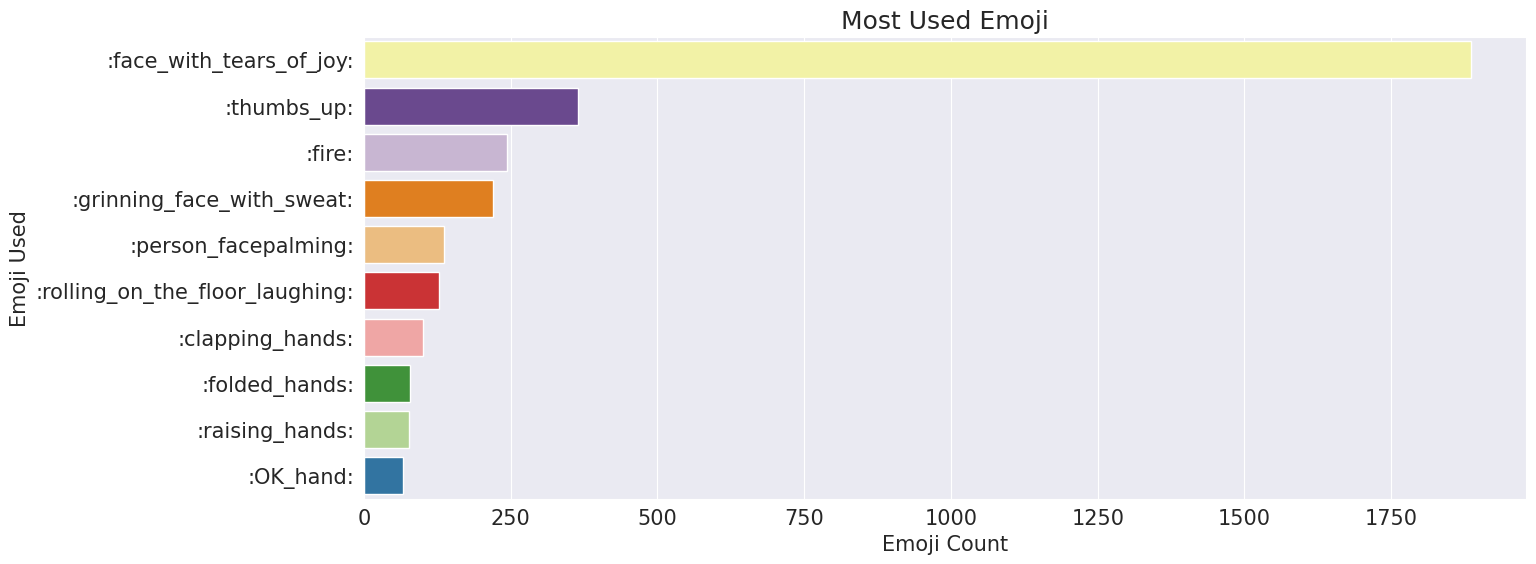

In [29]:
# Increasing the figure size
plt.figure(figsize=(15, 6))

# Better Readablity
import matplotlib
matplotlib.rcParams['font.size'] = 15

# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")

# Plotting;
sns.barplot(x='emoji_count', y='emoji_description', data=top10emojis, palette='Paired_r')

plt.title('Most Used Emoji')
plt.xlabel('Emoji Count')
plt.ylabel('Emoji Used');

# Saving the plots
plt.savefig('top10emoji.svg', format = 'svg')

#### Not that it is worth anything, but "😂" beats everyone by a huge margin!

# 6. Most active days, most active hours, most active months.

### *Pre-processing*

In [30]:
df3 = df.copy()
df3['message_count'] = [1] * df.shape[0]    # helper column to keep a count.

df3['hour'] = df3['date_time'].apply(lambda x: x.hour)

grouped_by_time = df3.groupby('hour').sum().reset_index().sort_values(by = 'hour')

### Which hour of the day are most messages exchanged?

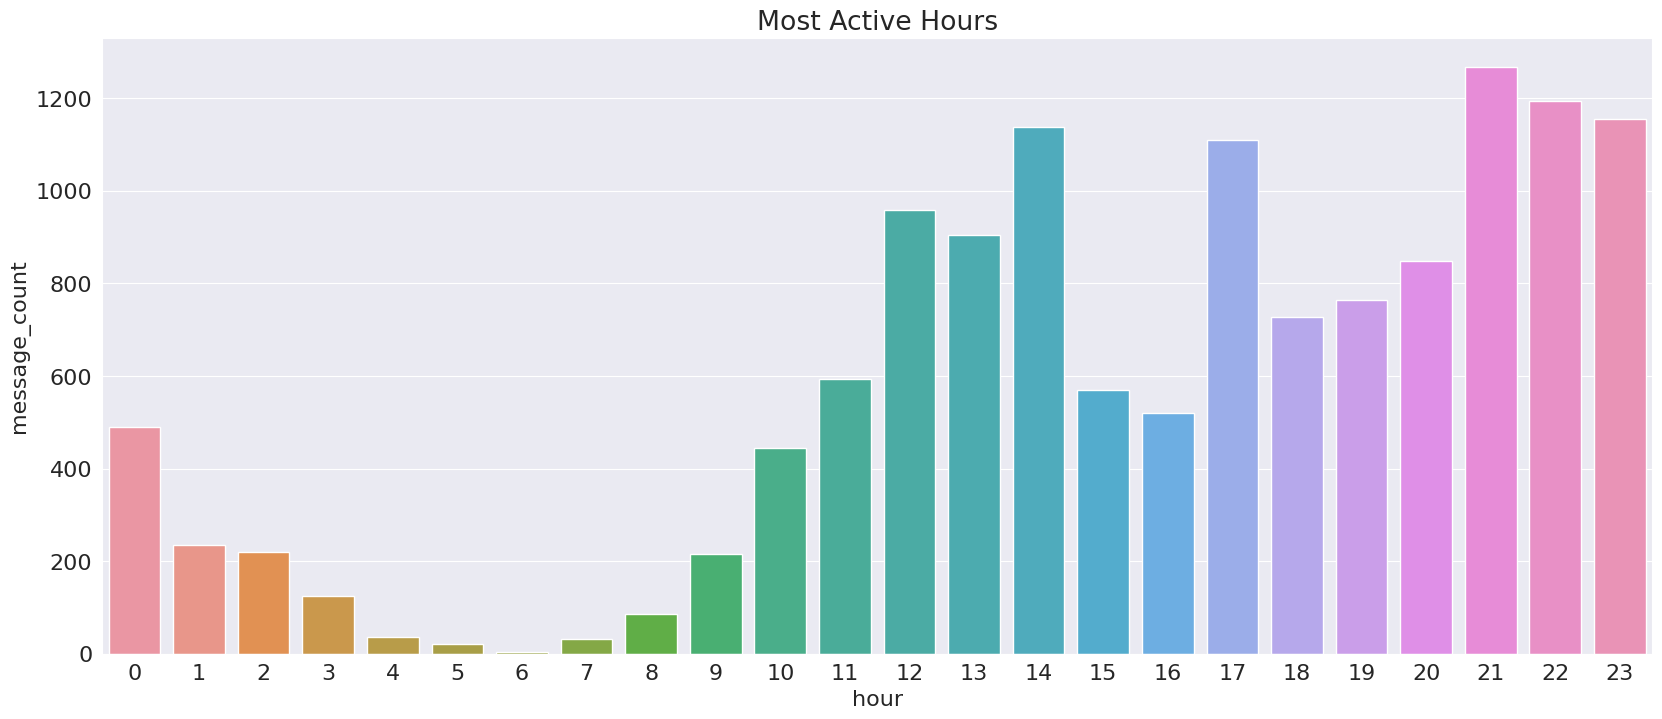

In [31]:
# Better Readablity
import matplotlib
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['figure.figsize'] = (20, 8)

# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")

# PLOT: grouped by hour
sns.barplot(x='hour', y='message_count', data=grouped_by_time)

plt.title('Most Active Hours');

# Saving the plots;
plt.savefig('most_active_hours.svg', format = 'svg')

#### Intrestingly, the group is *most active around midnight*, followed by *afternoon*.

### *Pre-processing weekdays and months*

In [32]:
# specific `order` to be printed in;
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
# grouping by day;
grouped_by_day = df3.groupby('day').sum().reset_index()[['day', 'message_count']]


# specific `order` to be printed in;
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']   # till Sept, since chats are till Septemeber
# grouping by month;
grouped_by_month = df3.groupby('month').sum().reset_index()[['month', 'message_count']]


## *Visualization*
### Now, we will be plotting *grouped by day* and respective *group by month* simultaneously, to see some interesting results.
- Using `plt.subplots` to plot multiple charts in a grid.

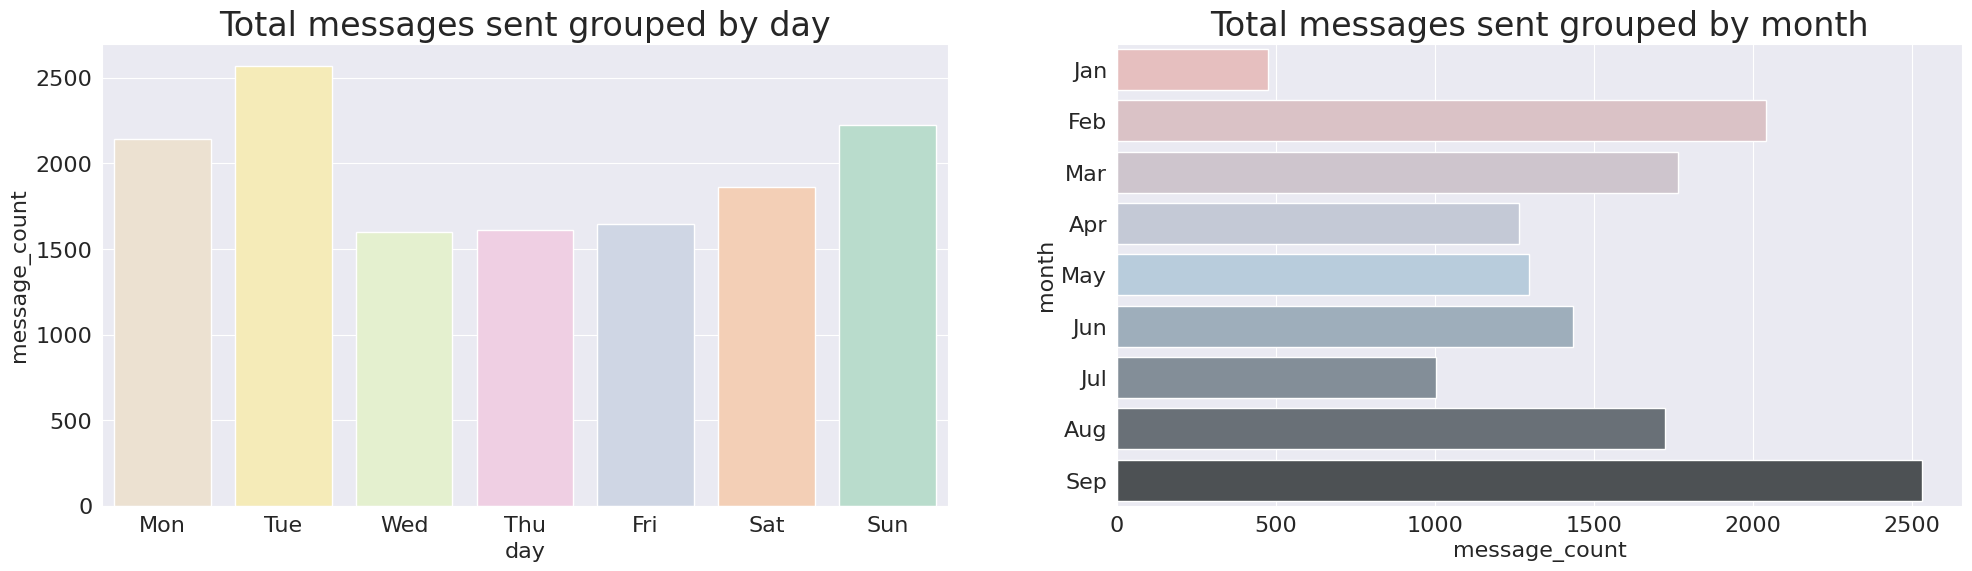

In [33]:
fig, axs = plt.subplots(1, 2, figsize = (24, 6))

# Better Readablity
import matplotlib
matplotlib.rcParams['font.size'] = 20

# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")

# Plotting;

# PLOT 1: Messages grouped by weekday
sns.barplot(x='day', y='message_count', data=grouped_by_day, order=days, ax=axs[0], palette='Pastel2_r')
axs[0].set_title('Total messages sent grouped by day')

# PLOT 2: Messages grouped by months
sns.barplot(y = grouped_by_month.month, x=grouped_by_month.message_count, order = months, ax = axs[1], palette='Pastel1_d')
axs[1].set_title('Total messages sent grouped by month');

# Saving the plots;
plt.savefig('days_and_month.svg', format = 'svg')

##### The group is most active on Sundays, and least active on Mondays (probably *Monday Blues*)
##### It has been recently very active, in September.

### Now, we will plot a *heatmap*, combining the above to bar plots, for a better understanding! 

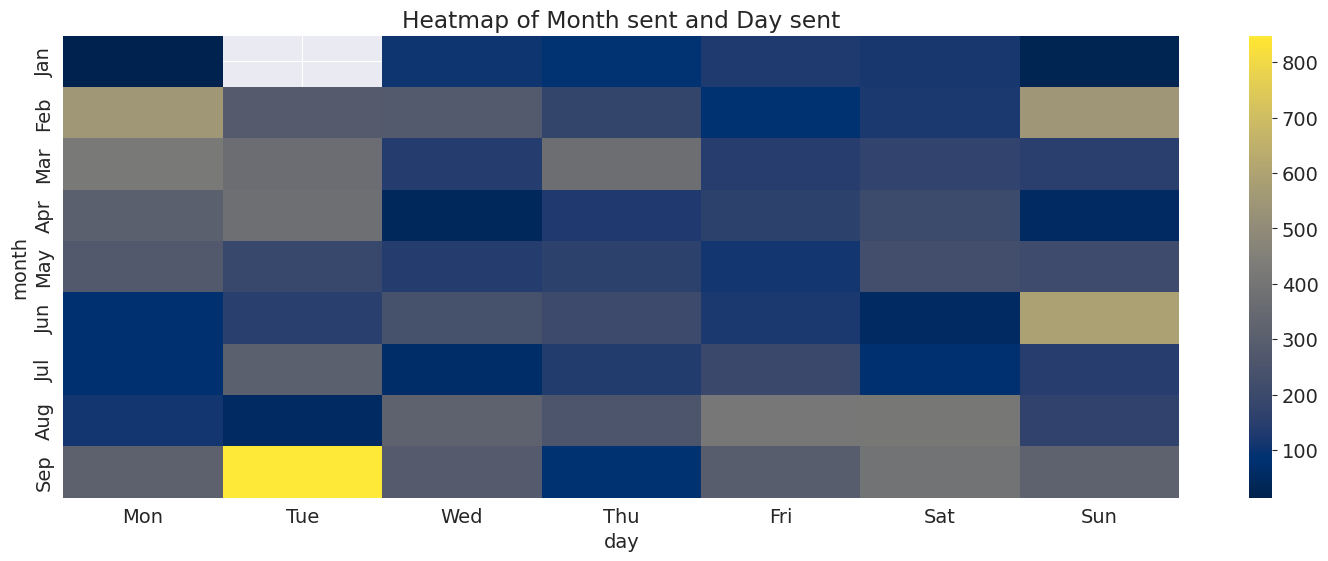

In [34]:
# Better Readablity
import matplotlib
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (18, 6)

# Beautifying Default Styles using Seaborn,
sns.set_style("darkgrid")

# Pre-Processing by month and day,
grouped_by_month_and_day = df3.groupby(['month', 'day']).sum().reset_index()[['month', 'day', 'message_count']]

# creating a pivot table,
pt = grouped_by_month_and_day.pivot_table(index = 'month', columns = 'day', values = 'message_count').reindex(index = months, columns = days)

# PLOT: heatmap.
sns.heatmap(pt, cmap = 'cividis');
plt.title('Heatmap of Month sent and Day sent');

# Saving the plots;
plt.savefig('month_day_heatmap.svg', format = 'svg')

# Most used words in the chat.
### Finally, I will be ending with *the most used words*, using `WordCloud` module in Python.

In [35]:
comment_words = ' '

# stopwords --> Words to be avoided while forming the WordCloud,
# removed group_notifications like 'joined', 'deleted';
# removed really common words like "yeah" and "okay".
stopwords = STOPWORDS.update(['group', 'link', 'invite', 'joined', 'message', 'deleted', 'yeah', 'hai', 'yes', 'okay', 'ok', 'will', 'use', 'using', 'one', 'know', 'guy', 'group', 'media', 'omitted'])


# iterate through the DataFrame.
for val in df3.message.values:
    
    # typecaste each val to string.
    val = str(val) 
    
    # split the value.
    tokens = val.split() 
    
    # Converts each token into lowercase.
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 8).generate(comment_words) 

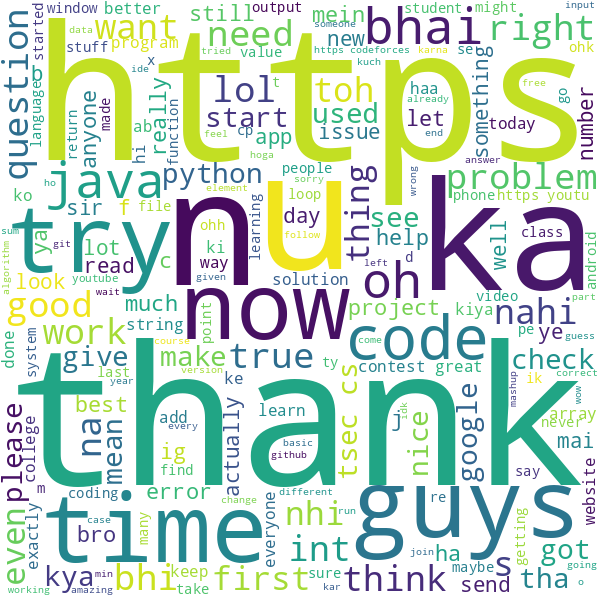

In [36]:
wordcloud.to_image()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


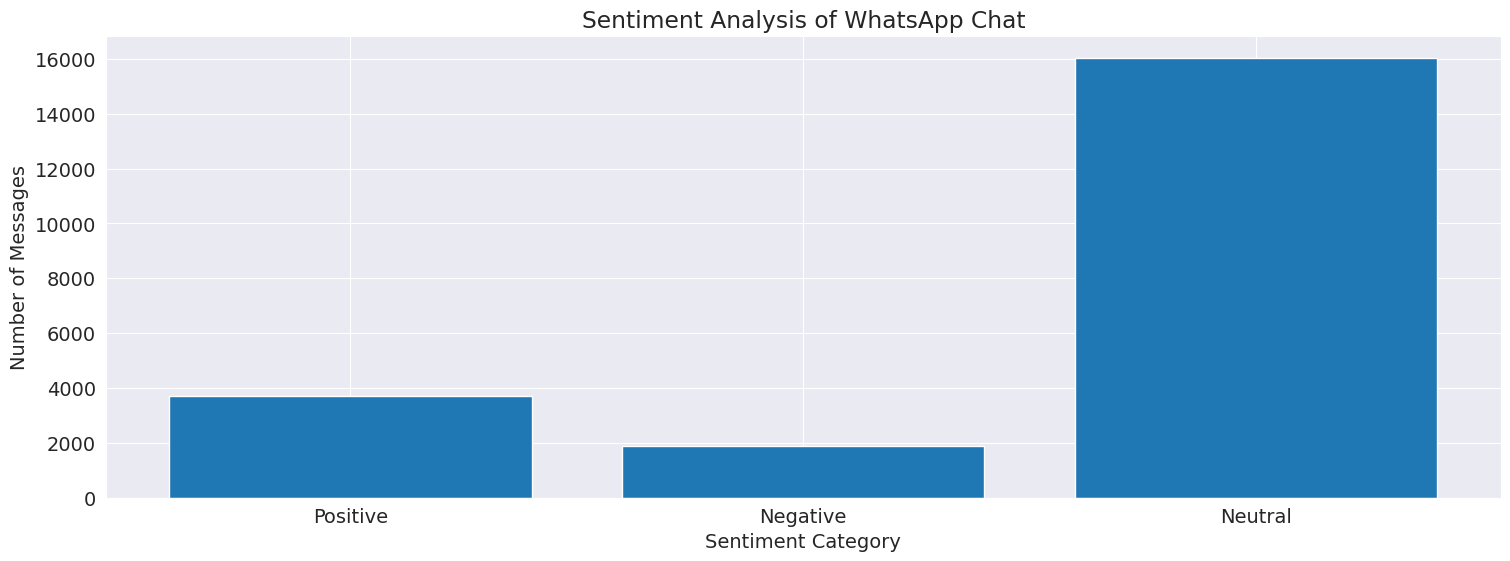

In [37]:
import nltk
nltk.download('vader_lexicon')
import matplotlib.pyplot as plt

from nltk.sentiment.vader import SentimentIntensityAnalyzer
#Valence Aware Dictionary and sEntiment Reasoner

# read in the WhatsApp chat text document
with open('whatsapp-chat-data.txt', 'r') as file:
    chat_text = file.read()

# initialize the sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# split the chat text into individual messages
messages = chat_text.split('\n')

# initialize counters for the sentiment categories
positive_count = 0
negative_count = 0
neutral_count = 0

# analyze the sentiment of each message and update the counters
for message in messages:
    if len(message) > 0:
        sentiment = analyzer.polarity_scores(message)
        if sentiment['compound'] > 0.1:
            positive_count += 1
        elif sentiment['compound'] < -0.1:
            negative_count += 1
        else:
            neutral_count += 1

# create a bar chart of the sentiment counts
sentiment_counts = [positive_count, negative_count, neutral_count]
sentiment_labels = ['Positive', 'Negative', 'Neutral']
plt.bar(sentiment_labels, sentiment_counts)
plt.title('Sentiment Analysis of WhatsApp Chat')
plt.xlabel('Sentiment Category')
plt.ylabel('Number of Messages')
plt.show()

The compound score is a single metric that ranges from -1 (very negative) to +1 (very positive), and represents an overall sentiment score for the message.

In [42]:
# # analyze the sentiment of each message
# for message in messages:
#     if len(message) > 0:
#         sentiment = analyzer.polarity_scores(message)
#         print(message.strip() + '\nSentiment: ' + str(sentiment) + '\n')
# analyze the sentiment of each message
# for i, message in enumerate(messages):
#     if len(message) > 0:
#         sentiment = analyzer.polarity_scores(message)
#         print(message.strip() + '\nSentiment: ' + str(sentiment) + '\n')
        
#         if i == 9:
#             break
import random

# Shuffle the messages list
random.shuffle(messages)

# Select the first 10 messages
random_messages = messages[:10]

# Analyze the sentiment of each message and print the results
for message in random_messages:
    if len(message) > 0:
        sentiment = analyzer.polarity_scores(message)
        print(message.strip() + '\nSentiment: ' + str(sentiment) + '\n')


22/07/2022, 5:37 pm - Tanay Kamath (TSEC, CS): CP wale sir💯
Sentiment: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

26/08/2022, 5:07 pm - +91 98337 47258: We had her in SE too
Sentiment: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

kaffan_69
Sentiment: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

23/06/2022, 1:58 pm - Darshan Rander (TSEC, IT): yes
Sentiment: {'neg': 0.0, 'neu': 0.722, 'pos': 0.278, 'compound': 0.4019}

25/04/2022, 9:56 pm - Dheeraj Lalwani (TSEC, CS): I can help with the README.md
Sentiment: {'neg': 0.0, 'neu': 0.803, 'pos': 0.197, 'compound': 0.4019}

21/08/2022, 4:57 pm - Harsh Kapadia (TSEC IT, SE): Have a look at this
Sentiment: {'neg': 0.209, 'neu': 0.791, 'pos': 0.0, 'compound': -0.4404}

01/07/2022, 10:15 am - Dheeraj Lalwani (TSEC, CS): The most positive person, I've ever come across.
Sentiment: {'neg': 0.0, 'neu': 0.782, 'pos': 0.218, 'compound': 0.5984}

26/06/2022, 1:39 pm - Pratik K (TSEC CS, SE): 😂😂🥴
Sentiment: {'neg': 0.0, '

# *Conclusion*

- The insights were really interesting to look at!

- We first loaded the data as a .txt file coverted it using `RawtoDF` function.
- Then  we added helper columns, manipulated datetime entries.
- Then, we started analysing our whatsapp data!

Here is what we looked at!

**1. Overall frequency of total messages on the group.**

**2. Top 10 most active days.**

**3. Top 10 active users on the group (with a twist - Most active user had the least average message length ).**
- Ghosts present in the group. (shocking results - 80+ participants who haven't even sent a single message!)

**4. Top 10 users most sent media.**
- *TK* beats everyone by a mile!

**5. Top 10 most used emojis.**
- using the `emoji` module!

**6. Most active hours and weekdays.**
 - Heatmaps of weekdays and months.
 - Most active hours, weekdays, and months.

**7. Most used words - WordCloud.**

**8. Sentimental Analysis**

### That's it from my end! I hope you *learnt and enjoyed* a lot!